In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict  


%matplotlib inline
plt.style.use('seaborn-white')



In [3]:
dataset="bank-additional-full.csv"
bankdata=pd.read_csv(dataset, delimiter=";")
bankdata["response"] = bankdata.y.map({'no':0, 'yes':1})

bankdata.drop(["y"],axis=1, inplace=True)
#bankdata.info()
#(bankdata.response==0).sum()

#bankdata.age.unique()

In [4]:
bankdata.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [5]:
#The method .copy() is used here so that any changes made in new DataFrame don't get reflected in the original one
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #dataframe of columns with object type columns

#print(cat_bankdata.isnull().values.sum()) #checking for the null values
#print(cat_bankdata.isnull().sum()) #check the column-wise distribution of null values
int_float_bankdata= bankdata.select_dtypes(include=['int64','float64']).copy() #dataframe of columns with int64,float64 type columns
int_float_bankdata.shape #includes response


(41188, 11)

In [6]:
#converting categories into numeric types(numeric encoding)

cat_column=cat_bankdata.columns.tolist()

for i in cat_column:
    cat_bankdata[i] = cat_bankdata[i].astype('category')
    cat_bankdata[i] = cat_bankdata[i].cat.codes
    
cat_bankdata.head() 

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [7]:
from sklearn.feature_selection import VarianceThreshold

var_bankdata=pd.concat([int_float_bankdata,cat_bankdata],axis=1)

#EX/ threshold=0.1 which means that if the variance of the values in a column is less than 0.1, remove those columns.
#In other words, remove feature column where approximately 99% of the values are similar.
variance_filter = VarianceThreshold(threshold=0.1)
bankdata_filtered=variance_filter.fit(var_bankdata)  

#Now to get all the features that are NOT CONSTANT, we can use the get_support() method of the filter that we created
len(var_bankdata.columns[variance_filter.get_support()]) 

#the number of constant features with the help of the following script:
constant_columns = [column for column in var_bankdata.columns  
                    if column not in var_bankdata.columns[variance_filter.get_support()]]

#print(variable_columns)
#print(int_float_bankdata.columns[variance_filter.get_support()])
bankdata_filtered=var_bankdata[var_bankdata.columns[variance_filter.get_support()]]


In [8]:
bankdata_filtered.info()  #not include "response"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
job               41188 non-null int8
marital           41188 non-null int8
education         41188 non-null int8
default           41188 non-null int8
housing           41188 non-null int8
loan              41188 non-null int8
contact           41188 non-null int8
month             41188 non-null int8
day_of_week       41188 non-null int8
poutcome          41188 non-null int8
dtypes: float64(5), int64(5), int8(10)
memory usage: 3.5 MB


In [9]:
print(constant_columns)

['response']


In [10]:
#Let's use chi-square test to understand relationship between categorical variables and target variable.
#Null Hypothesis which is these features are independent and have no relationship with target variable.

from scipy.stats import chi2_contingency

no_relation_list=[]
for i in cat_bankdata.columns.tolist():
    csq=chi2_contingency(pd.crosstab(bankdata["response"], cat_bankdata[i]))
    print("P-value: ",i, ">>",csq[1])
    if csq[1]>0.05:
        no_relation_list.append(i)

P-value:  job >> 4.189763287563861e-199
P-value:  marital >> 2.068014648442211e-26
P-value:  education >> 3.3051890144025054e-38
P-value:  default >> 5.1619579513916376e-89
P-value:  housing >> 0.05829447669453452
P-value:  loan >> 0.5786752870441754
P-value:  contact >> 1.5259856523129964e-189
P-value:  month >> 0.0
P-value:  day_of_week >> 2.9584820052785324e-05
P-value:  poutcome >> 0.0


In [11]:
print(no_relation_list)

['housing', 'loan']


In [12]:
#print(no_relation_column)  #returns ['housing', 'loan']
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #reassigning cat_bankdata for one-hot-encoding
cat_bankdata.drop(columns=list(no_relation_list), axis=1, inplace=True)  
cat_bankdata.head()

,job,marital,education,default,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,telephone,may,mon,nonexistent
2,services,married,high.school,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,telephone,may,mon,nonexistent


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000074BDA26F28>,
      dtype=object)

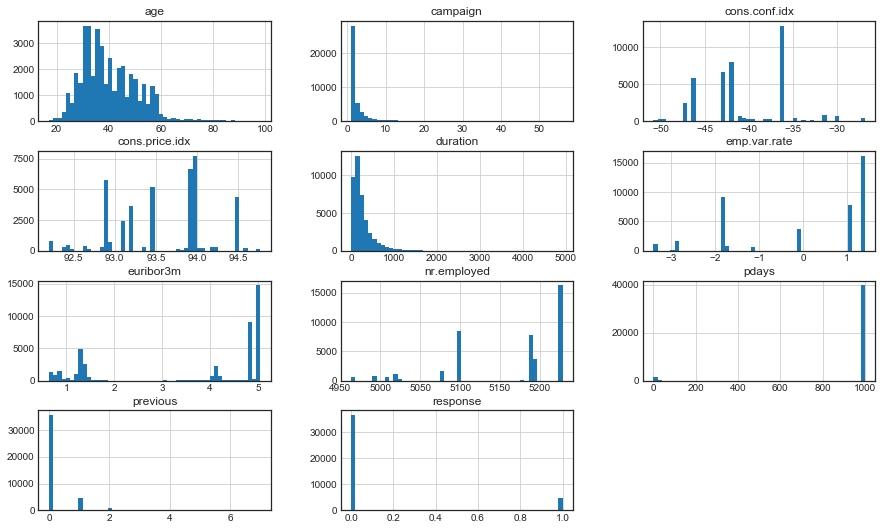

In [11]:
int_float_bankdata.hist(figsize=(15,9),bins=50)

In [13]:
#creating dummy variables from categorical features (One-Hot encoding)>> this has the benefit of not weighting a value improperly.
#sklearn has "LabelBinarizer" class for one- hot encoding

cat_bankdata_dummy = cat_bankdata.copy()
cat_column_list=cat_bankdata.columns.tolist()

cat_bankdata_dummy = pd.get_dummies(cat_bankdata_dummy, columns=cat_column_list, prefix = cat_column_list,drop_first=True)
#In order to reduce the correlation among variables,simply remove one feature column,by assigning "drop_first" argument to "True", from the one-hot encoded array,

print(cat_bankdata_dummy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 39 columns):
job_blue-collar                  41188 non-null uint8
job_entrepreneur                 41188 non-null uint8
job_housemaid                    41188 non-null uint8
job_management                   41188 non-null uint8
job_retired                      41188 non-null uint8
job_self-employed                41188 non-null uint8
job_services                     41188 non-null uint8
job_student                      41188 non-null uint8
job_technician                   41188 non-null uint8
job_unemployed                   41188 non-null uint8
job_unknown                      41188 non-null uint8
marital_married                  41188 non-null uint8
marital_single                   41188 non-null uint8
marital_unknown                  41188 non-null uint8
education_basic.6y               41188 non-null uint8
education_basic.9y               41188 non-null uint8
education_high.school      

In [14]:
int_float_bankdata.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [15]:
#Concatenating back with the remaining columns, which can be done via pandas' .concat() method. 
#The axis argument is set to 1 as you want to merge on columns.

resulting_bankdata = pd.concat([cat_bankdata_dummy, int_float_bankdata], axis=1)
resulting_feature_set=resulting_bankdata.drop(["response"],axis=1) #response variable excluded

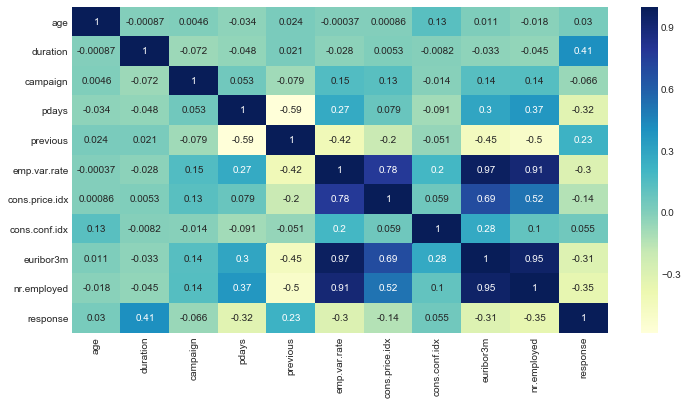

In [16]:
#Correlation plot

correlation_matrix=bankdata.corr()
plt.figure(figsize=(12,6))

sns.heatmap(correlation_matrix,cmap="YlGnBu",annot=True)

In [17]:
#Removing Correlated Features
#Two or more than two features are correlated if they are close to each other in the linear space.
#Correlation between the output observations and the input features is very important and such features should be retained.
#Removing Correlated Features using corr() method returns a correlation matrix containing correlation between all the columns of the dataframe

correlated_features = set()   #creating empty set
correlation_matrix = int_float_bankdata.corr()  

for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [18]:
print(correlated_features)

{'euribor3m', 'nr.employed'}


In [19]:
#These correlated columns convey similar information to the learning algorithm and therefore, should be removed            
#The following script removes these columns from the dataset:


resulting_feature_set.drop(columns=list(correlated_features), axis=1, inplace=True)  

In [20]:
from sklearn.model_selection import train_test_split
#It’s necessary to use stratify when the labels are imbalanced 

X_train_GBC, X_test_GBC, y_train_GBC, y_test_GBC = train_test_split(resulting_feature_set, bankdata["response"], test_size=0.3, random_state=0,stratify=bankdata["response"])

In [21]:
#Dataset is imbalanced, hence trying oversampling
#Applying Synthetic Minority Oversampling Technique (SMOTE)-applies KNN approach

from imblearn.over_sampling import SMOTE
from collections import Counter

X_train_GBC, y_train_GBC = SMOTE().fit_resample(X_train_GBC, y_train_GBC)
print(sorted(Counter(y_train_GBC).items()))

Using TensorFlow backend.


[(0, 25583), (1, 25583)]


In [22]:
print(X_train_GBC.shape,X_test_GBC.shape)

(51166, 47) (12357, 47)


In [23]:
#GRIDSEARCH

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_dist = {'max_features' : ['log2',0.5,1.0],
              'max_depth' : [2,3,6],
              'min_samples_leaf' : [1,2,3,10],
              'n_estimators': [50,100],
              'learning_rate' : [0.1,0.2,0.3,1],
              'loss' : ['deviance']
              }

classif_GBC = RandomizedSearchCV(GradientBoostingClassifier(warm_start=True),
                              param_distributions = param_dist,
                              cv=5,
                              n_iter=6, n_jobs=-1,return_train_score=True,scoring='roc_auc')

classif_GBC.fit(X_train_GBC,y_train_GBC)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [24]:
print("Best parameters :" , classif_GBC.best_params_, "\n") 
print("Best score :" , classif_GBC.best_score_, "\n") 
print("Best estimator :", classif_GBC.best_estimator_, "\n")
pd.DataFrame(classif_GBC.cv_results_)
    

Best parameters : {'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.2} 

Best score : 0.9908880888257066 

Best estimator : GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=3,
                           max_features=0.5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True) 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,param_learning_rate,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,18.174382,3.563813,0.105792,0.017498,50,3,0.5,2,deviance,1,...,0.983576,0.030975,4,0.999944,0.989935,0.990062,0.990401,0.990416,0.992152,0.003901
1,8.952469,1.775615,0.120820,0.033952,50,3,log2,3,deviance,1,...,0.982167,0.033792,5,0.999962,0.989960,0.990261,0.990428,0.989645,0.992051,0.003965
2,8.039350,1.300482,0.122615,0.041717,50,10,log2,2,deviance,0.2,...,0.981149,0.021053,6,0.995732,0.981173,0.980758,0.982514,0.982168,0.984469,0.005668
3,60.372251,4.460655,0.301614,0.091867,100,10,0.5,3,deviance,0.2,...,0.990888,0.017150,1,0.999977,0.991999,0.992062,0.992209,0.992040,0.993658,0.003160
4,35.488487,3.836575,0.167431,0.036089,100,10,0.5,2,deviance,0.2,...,0.989376,0.018572,3,0.999787,0.989913,0.990221,0.990309,0.990307,0.992107,0.003842
5,32.608508,5.685079,0.184007,0.088972,100,10,0.5,2,deviance,0.3,...,0.989823,0.018778,2,0.999946,0.991030,0.990754,0.990857,0.991384,0.992794,0.003582


In [25]:
GBC_model=classif_GBC.best_estimator_ #no need to fit, since previously fitted.(classif_GBC and GBC_model are same estimators)

In [26]:
#Persisting models with joblib
from sklearn.externals import joblib
joblib.dump(GBC_model, "GBC_model.clf")


C:\Anaconda_last\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['GBC_model.clf']

In [27]:
#Load the model with joblib. Make a prediction with a set of inputs:

from sklearn.externals import joblib
pulled_model = joblib.load("GBC_model.clf")
print(pulled_model)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=3,
                           max_features=0.5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=True)


In [28]:
# Make predictions
preds_GBC = GBC_model.predict(X= X_test_GBC)
preds_GBC = pd.Series(preds_GBC)


In [29]:
# ROC curve and Area-Under-Curve (AUC)

fpr_GBC, tpr_GBC, _ = roc_curve(y_test_GBC, preds_GBC)
roc_auc_GBC = auc(fpr_GBC, tpr_GBC)
print("Area under ROC curve = {:0.2f}".format(roc_auc_GBC))

# Generate table of predictions
contingency_table_GBC = pd.crosstab(preds_GBC, y_test_GBC ,margins=True)
print(contingency_table_GBC)


Area under ROC curve = 0.75
response     0    1   All
row_0                    
0         3222  126  3348
1          357   12   369
All       3579  138  3717


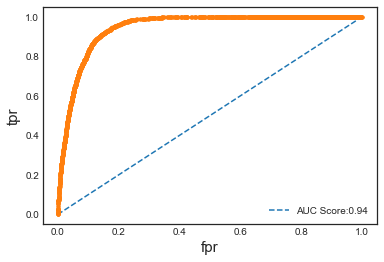

AUC: 0.943


In [27]:
y_pred_prob_GBC = GBC_model.predict_proba(X_test_GBC)
fpr, tpr, thresholds = roc_curve(y_test_GBC, y_pred_prob_GBC[:,1])
auc_score = roc_auc_score(y_test_GBC, y_pred_prob_GBC[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('fpr',fontsize='15')
plt.ylabel('tpr',fontsize='15')
plt.legend(["AUC Score:" + "{0:.2f}".format(auc_score)],)
plt.show()

print('AUC: %.3f' % auc_score)


In [30]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=7)
accuracy = cross_val_score(GBC_model,X_train_GBC, y_train_GBC,cv=list(kfold.split(X_train_GBC, y_train_GBC)),scoring="roc_auc")
print ("Cross-validated scores:", accuracy)

Cross-validated scores: [0.9931453  0.99306308 0.99169879 0.99249008 0.99229635 0.9922141 ]


In [32]:
from sklearn.model_selection import StratifiedShuffleSplit #This does not try to make folds with testing sets that are mutually exclusive

sss = StratifiedShuffleSplit(n_splits = 6,test_size=0.25)
accuracy = cross_val_score(GBC_model,X_train_GBC, y_train_GBC,cv=list(sss.split(X_train_GBC, y_train_GBC)),scoring="roc_auc")
print ("Cross-validated scores:", accuracy)

Cross-validated scores: [0.99215155 0.99252698 0.9921435  0.99270398 0.99224533 0.99258058]


In [31]:
#We do not need to call the fit method separately while using cross validation, the cross_val_score method fits the data
#itself while implementing the cross-validation on data.

from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_shuffle=cross_val_score(GBC_model,X_train_GBC, y_train_GBC,scoring="roc_auc", cv=cv)  
print ("Cross-validated scores:", acc_shuffle)  #The Accuracy of the model is the average of the accuracy of each fold.
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_shuffle.mean(), acc_shuffle.std() * 2))


Cross-validated scores: [0.99273104 0.99254335 0.99248477 0.99270345 0.9916489  0.9930815
 0.99298082 0.9927377  0.99292195 0.99259014]
Accuracy: 0.99 (+/- 0.00)


In [33]:
#OR >>
roc_accuracy = cross_val_score(GBC_model,X_train_GBC, y_train_GBC,scoring="roc_auc", cv=12)
print ("Cross-validated scores:", roc_accuracy)  #he Accuracy of the model is the average of the accuracy of each fold.
print("Accuracy: %0.2f (+/- %0.2f)" % (roc_accuracy.mean(), roc_accuracy.std() * 2))

Cross-validated scores: [0.94477028 0.97209622 0.99977846 0.99962512 0.999692   0.99946892
 0.99974348 0.99961874 0.99956726 0.99957452 0.99954922 0.99941667]
Accuracy: 0.99 (+/- 0.03)


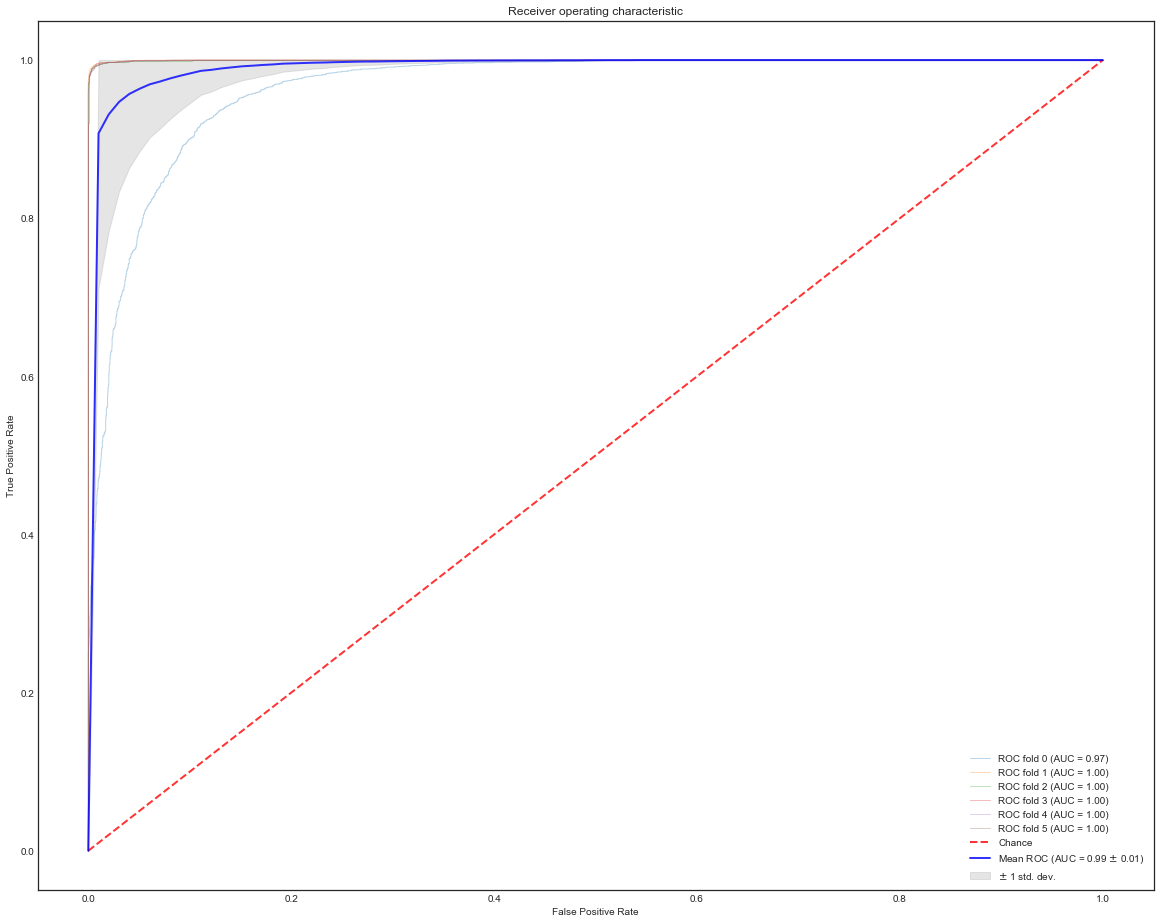

In [39]:
#Receiver Operating Characteristic (ROC) with cross validation
from scipy import interp
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(20,16))

i = 0
for train, test in cv.split(X_train_GBC, y_train_GBC):
    probas_ = GBC_model.fit(X_train_GBC[train], y_train_GBC[train]).predict_proba(X_train_GBC[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_train_GBC[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()